In [ ]:
import numpy as np
import torch as tc
from torch import nn

import gymnasium as gym

from agents import *
from train import obs_to_state

import mlflow
from tqdm import trange
import matplotlib.pyplot as plt

DEVICE = "cpu"

In [ ]:
# select model
Model: type[Learner] = ScaledRewardLearner
path_weight = "weights/full_plain/"

# select environment (action space has to be discrete)
env_name = "MountainCar-v0"

# select settings
EPOCH = 7000
SHOW_WINDOW = True
N_STEPS = 500

In [ ]:
# create environment
if SHOW_WINDOW:
    env_vis = gym.make(env_name, max_episode_steps=N_STEPS, render_mode="human")
else:
    env_vis = gym.make(env_name, max_episode_steps=N_STEPS)

# load agent from checkpoint
with tc.serialization.safe_globals([nn.BatchNorm1d]):
    agent_vis = Model.load(path_weight, EPOCH, DEVICE)
agent_vis.eval()

# create action lookup
n_actions = int(env_vis.action_space.n) # type: ignore
actions_onehot = tc.eye(n_actions, dtype=tc.int, device=agent_vis.device)

# keep track of states & actions
states = []
actions = []

# reset environment
observation, info = env_vis.reset() 


tqdm_iter = trange(N_STEPS)
for t in tqdm_iter:
    with tc.no_grad():
        state = obs_to_state(observation, DEVICE).unsqueeze(0)

        action = agent_vis.act(state, actions_onehot).squeeze()

    # perform step
    observation, reward, terminated, truncated, info = env_vis.step(action)

    # store state & action
    states.append(state)
    actions.append(float(action))

    # update progress bar title
    tqdm_iter.set_description(f"Chose action {action}")

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env_vis.reset()

env_vis.close()

Chose action 2: 100%|██████████| 500/500 [00:16<00:00, 29.59it/s]


In [ ]:
env_vis.close()

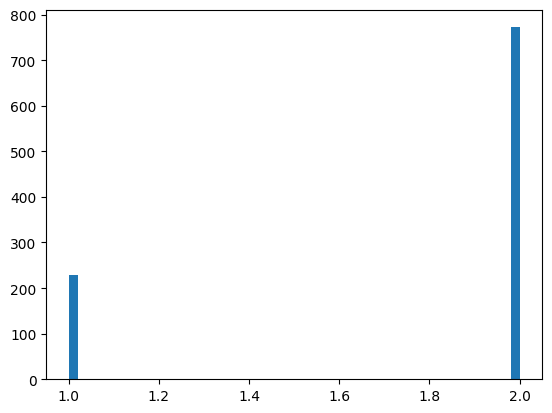

In [ ]:
plt.hist(actions, bins=50)
plt.xticks()
plt.show()

# Metric retrieval

In [8]:
mlflow.set_tracking_uri("http://10.30.20.11:5000")
mlflow.set_experiment("jheis_SRL_MountainCar-v0")

client = mlflow.tracking.MlflowClient() # type: ignore

In [9]:
run_id = "f70604c2f06147de9d7577b04016208a"

get_history = lambda name: np.array(list(map(lambda x: x.value, client.get_metric_history(run_id, name))))

history_lq1 = get_history("loss_q1")
history_lq2 = get_history("loss_q2")
history_el = get_history("episode_length")
history_q = get_history("q")
history_reward = get_history("mean_reward")

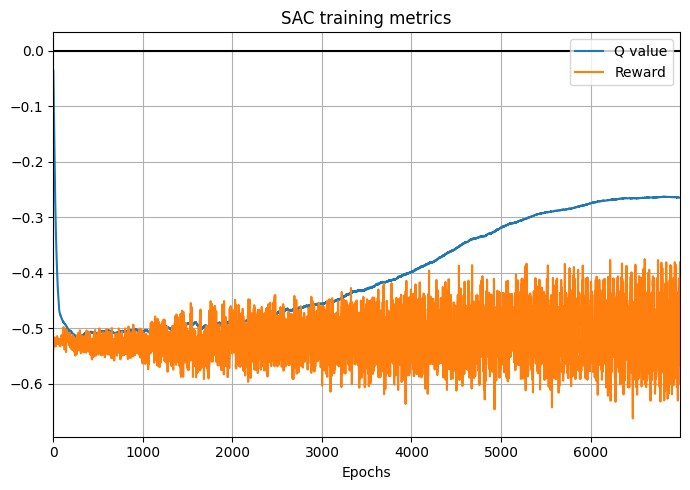

In [11]:
plt.figure(figsize=(7, 5))

xmin = 0
xmax = len(history_q) - 1
plt.hlines([0], xmin, xmax, colors="black")
# plt.plot(history_lq1, label="Q loss")
plt.plot(history_q, label="Q value")
plt.plot(history_reward, label="Reward")
# plt.plot(history_el > 200)
# plt.plot(history_reward)
# plt.semilogy()
# plt.ylim(38, 40)

plt.xlim(xmin, xmax)
plt.grid()
plt.legend()
plt.title("SAC training metrics")
plt.xlabel("Epochs")
plt.tight_layout()
plt.show()